In [22]:
# Importamos las librerías necesarias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 


import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [79]:
# Leemos la tabla final tras los tratamientos y el balanceo :
merged_df_id = pd.read_csv('df_balanceado_id.csv')
columnsToDrop = ["Unnamed: 0.1","index"]
merged_df_id = merged_df_id.drop(columns=columnsToDrop)

In [82]:
merged_df_id = merged_df_id.drop(columns=["Unnamed: 0"])

In [84]:
merged_df_id = merged_df_id.drop(columns=["con_id"])

In [137]:
merged_df_id.head()

,msf_annualizedquota__c,msf_LTVCont__c,msf_ScoringRFVRecurringDonor__c,msf_AverageDonorValue__c,msf_changeannualizedquota__c,msf_newannualizedquota__c,year_activo,age,msf_seniority__c,npe03__installment_period__c_Monthly,npe03__installment_period__c_Quarterly,npe03__installment_period__c_Semestral,npe03__installment_period__c_Yearly,Gender__c_Male,Gender__c_Other,msf_PressureComplaint__c_True,Gender__c_Male.1,Gender__c_Other.1,msf_leadsource3__c_Entidad financiera,msf_leadsource3__c_Online,msf_leadsource3__c_Otro,msf_leadsource3__c_Personal,msf_leadsource3__c_Teléfono,msf_newrecurringperiod__c_Monthly,msf_newrecurringperiod__c_Quarterly,msf_newrecurringperiod__c_Semestral,msf_newrecurringperiod__c_Yearly,Provincia2_Madrid,Provincia2_Pais Vasco,Provincia2_Resto,Provincia2_Sevilla,agrup_currentleadsource_Personal con tablet,agrup_currentleadsource_Resto,agrup_currentleadsource_Telemarketing,agrup_currentleadsource_Teléfono campaña,agrup_currentleadsource_Web MSF,agrup_leadsource_Personal con tablet,agrup_leadsource_Resto,agrup_leadsource_Telemarketing,agrup_leadsource_Teléfono campaña,agrup_leadsource_Web MSF,flag_aumento
0,180.0,830.0,0.6,30.44,180.0,180.0,2015,55.0,9.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
1,60.0,300.0,1.8,30.44,60.0,60.0,2015,66.0,8.0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,300.0,1125.0,1.5,30.44,300.0,300.0,2015,35.0,8.0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,360.0,1200.0,1.5,30.44,360.0,360.0,2015,64.0,8.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,120.0,380.0,1.5,30.44,120.0,120.0,2015,32.0,8.0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [138]:
merged_df_id.flag_aumento.value_counts()

0    534658
1    320794
Name: flag_aumento, dtype: int64

In [96]:
merged_df_id.shape

(855452, 42)

In [97]:
merged_df_id[['year_activo']].drop_duplicates()

,year_activo
0,2015
127353,2016
245095,2017
353116,2018
430393,2019
495795,2020
548855,2021


## Realizamos el modelo utilizando los datos balanceados:

In [98]:
#Eliminamos de X la variable objetivo:
X = merged_df_id.drop("flag_aumento", axis = 1)
y = merged_df_id['flag_aumento']

In [99]:
# Separamos el dataset en conjunto de entrenamiento y trest:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(684361, 41)
(171091, 41)
(684361,)
(171091,)


In [100]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

#### REGRESIÓN LOGÍSTICA

In [101]:
import mlflow
mlflow.set_tracking_uri('http://localhost:5000')

In [15]:
#experiment = mlflow.create_experiment("msf-quote-logistic")

In [102]:
experiment = mlflow.get_experiment_by_name("msf-quote-logistic")
experiment

<Experiment: artifact_location='mlflow-artifacts:/373688635970897928', creation_time=1697888365834, experiment_id='373688635970897928', last_update_time=1697888365834, lifecycle_stage='active', name='msf-quote-logistic', tags={}>

In [103]:
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

In [104]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="msf-quote-logistic-regression") as run:
    # Probamos primero con un modelo de Regresión Logística
    classifier = LogisticRegression(random_state = 0)
    # Entrenamiento del modelo
    classifier.fit(X_train, Y_train)
    # Hacemos las predicciones sobre el conjunto de test
    y_pred  = classifier.predict(X_test)    
    #Recuperamos métricas
    metrics = get_metrics(Y_test, y_pred)
    # Registramos métricas
    mlflow.log_metric('test_accuracy', metrics['accuracy'])
    mlflow.log_metric('test_precision', metrics['precision'])
    mlflow.log_metric('test_recall', metrics['recall'])
    
        # Registramos el modelo
    mlflow.sklearn.log_model(classifier, 'msf-quote-logistic-regression')

##### Registramos y publicamos el modelo en MLFlow

In [105]:
msf_experiments = mlflow.search_runs(search_all_experiments=True)
msf_experiments.loc[msf_experiments['tags.mlflow.runName'] == 'msf-quote-logistic-regression']

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_recall,metrics.test_accuracy,metrics.test_precision,metrics.train_precision,metrics.train_recall,metrics.train_time,metrics.train_accuracy,params.max_depth,params.optimizer,params.epochs,params.nodes,params.final_learning_rate,params.n_layers,params.loss,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.runName,tags.mlflow.source.name
0,2505c9ab21e546cbb14434551e58af41,373688635970897928,FINISHED,mlflow-artifacts:/373688635970897928/2505c9ab2...,2023-10-21 15:33:24.092000+00:00,2023-10-21 15:33:31.509000+00:00,0.84,0.87,0.82,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,mlala,LOCAL,"[{""run_id"": ""2505c9ab21e546cbb14434551e58af41""...",msf-quote-logistic-regression,C:\Users\mlala\AppData\Local\Programs\Python\P...
2,aeab2e9f4ea24fa39a5c48b8fb304208,373688635970897928,FINISHED,mlflow-artifacts:/373688635970897928/aeab2e9f4...,2023-10-21 11:55:52.476000+00:00,2023-10-21 11:56:01.516000+00:00,0.84,0.87,0.82,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,mlala,LOCAL,"[{""run_id"": ""aeab2e9f4ea24fa39a5c48b8fb304208""...",msf-quote-logistic-regression,C:\Users\mlala\AppData\Local\Programs\Python\P...


In [106]:
model_uri = f"runs:/2505c9ab21e546cbb14434551e58af41/msf-quote-logistic-regression"

In [107]:
model_version = mlflow.register_model(
    model_uri,
    "msf-quote-logistic-regression"
)

Registered model 'msf-quote-logistic-regression' already exists. Creating a new version of this model...
2023/10/21 17:34:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: msf-quote-logistic-regression, version 2
Created version '2' of model 'msf-quote-logistic-regression'.


In [108]:
client = mlflow.tracking.MlflowClient()
model_prod = client.transition_model_version_stage(
    name='msf-quote-logistic-regression',
    version=2,
    stage="Production",
)

In [109]:
# Predecimos el conjunto test 
y_pred  = classifier.predict(X_test)

In [110]:
y_pred

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

**Métricas de calidad**

In [111]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90    107137
           1       0.82      0.84      0.83     63954

    accuracy                           0.87    171091
   macro avg       0.86      0.87      0.86    171091
weighted avg       0.87      0.87      0.87    171091



In [112]:
conf=pd.DataFrame(
    confusion_matrix(Y_test, y_pred),
    columns=['Predicción aumenta cuota', 'Predicción No aumenta cuota'],
    index  =['Verdadero aumenta cuota', 'Verdadero No aumenta cuota']
)
print(conf)

                            Predicción aumenta cuota  \
Verdadero aumenta cuota                        95766   
Verdadero No aumenta cuota                     10380   

                            Predicción No aumenta cuota  
Verdadero aumenta cuota                           11371  
Verdadero No aumenta cuota                        53574  


In [113]:
# Calculamos el accuracy
accuracy_score(Y_test, y_pred)

0.8728688241929733

In [114]:
# Área bajo la curva
roc_auc_score(Y_test, y_pred)

0.8657803542501966

In [115]:
# Calculamos la gráfica
fpr, tpr, threshold = roc_curve(Y_test, y_pred)

In [116]:
roc_auc = roc_auc_score(Y_test, y_pred)

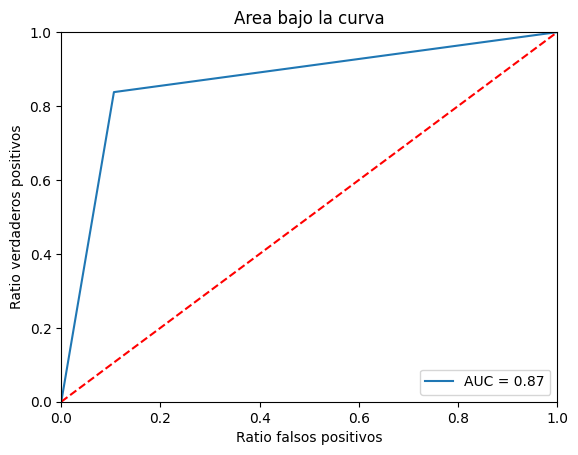

In [117]:
import matplotlib.pyplot as plt
plt.title("Area bajo la curva")
plt.plot(fpr, tpr, label = "AUC = %0.2f"% roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("Ratio verdaderos positivos")
plt.xlabel("Ratio falsos positivos")
plt.show()

##### ---------------------------------------------------------------------------------------------------------

##### Para crear un fichero de features o feature store nos quedamos con el registro más reciente para cada contacto

In [119]:
features = pd.read_csv('df_balanceado_id.csv')

# Sort the dataframe by 'whoid' and 'activityDate' in descending order
features = features.sort_values(by=['con_id', 'year_activo'], ascending=[True, False])

# Drop duplicate 'whoid' entries, keeping only the first occurrence (which is the most recent due to sorting)
features = features.drop_duplicates(subset='con_id', keep='first')

In [121]:
features = features.drop(columns=["Unnamed: 0","Unnamed: 0.1","index"])

In [124]:
features = features.drop(columns=["flag_aumento"])

In [122]:
features['year_activo'] = 2022

In [125]:
features.to_csv('lr_pandas_feature_store.csv', index=False)

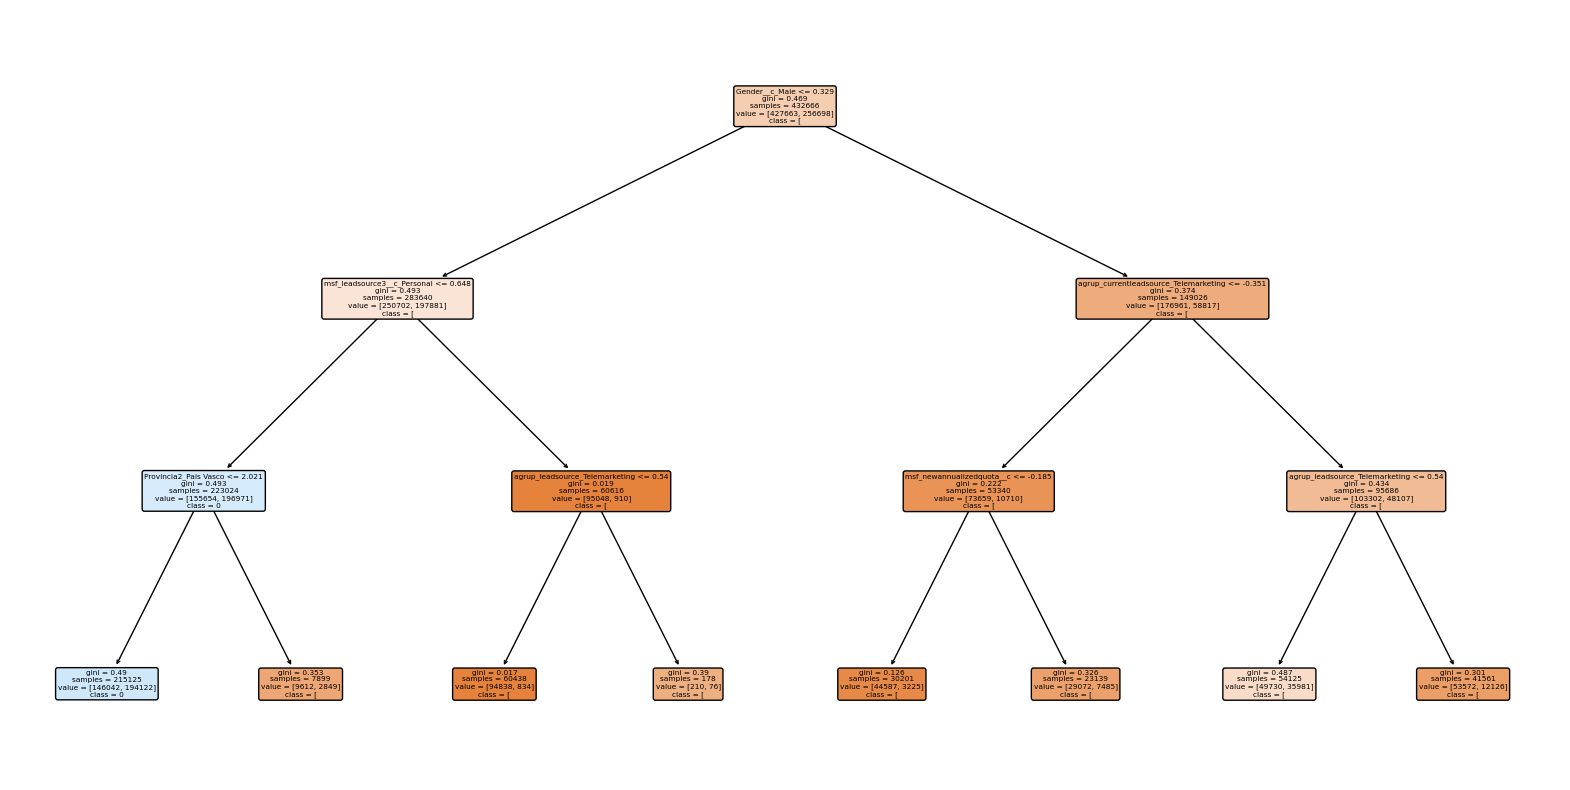

In [208]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
chosen_tree = rf_classifier.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(chosen_tree, filled=True, feature_names=X.columns.tolist(), class_names=str(y.unique()), rounded=True)
plt.show()

In [126]:
feature_store_id = features.con_id
feature_store_no_id = features.drop(columns=["con_id"])

In [127]:
feature_store_no_id.shape

(357693, 41)

In [128]:
feature_store_no_id.head()

,msf_annualizedquota__c,msf_LTVCont__c,msf_ScoringRFVRecurringDonor__c,msf_AverageDonorValue__c,msf_changeannualizedquota__c,msf_newannualizedquota__c,year_activo,age,msf_seniority__c,npe03__installment_period__c_Monthly,npe03__installment_period__c_Quarterly,npe03__installment_period__c_Semestral,npe03__installment_period__c_Yearly,Gender__c_Male,Gender__c_Other,msf_PressureComplaint__c_True,Gender__c_Male.1,Gender__c_Other.1,msf_leadsource3__c_Entidad financiera,msf_leadsource3__c_Online,msf_leadsource3__c_Otro,msf_leadsource3__c_Personal,msf_leadsource3__c_Teléfono,msf_newrecurringperiod__c_Monthly,msf_newrecurringperiod__c_Quarterly,msf_newrecurringperiod__c_Semestral,msf_newrecurringperiod__c_Yearly,Provincia2_Madrid,Provincia2_Pais Vasco,Provincia2_Resto,Provincia2_Sevilla,agrup_currentleadsource_Personal con tablet,agrup_currentleadsource_Resto,agrup_currentleadsource_Telemarketing,agrup_currentleadsource_Teléfono campaña,agrup_currentleadsource_Web MSF,agrup_leadsource_Personal con tablet,agrup_leadsource_Resto,agrup_leadsource_Telemarketing,agrup_leadsource_Teléfono campaña,agrup_leadsource_Web MSF
101931,60.0,760.50,0.4,30.44,60.0,60.0,2022,58.0,22.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
269461,144.0,2001.51,1.2,30.44,144.0,144.0,2022,76.0,22.0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
204451,120.0,670.15,0.7,100.00,120.0,120.0,2022,55.0,22.0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
131741,31.0,1306.35,3.0,300.00,31.0,31.0,2022,54.0,22.0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
464362,150.0,2580.70,4.2,30.44,150.0,150.0,2022,78.0,22.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [188]:
feature_store_no_id_sc = sc_X.transform(feature_store_no_id)

In [189]:
predictions = classifier.predict(feature_store_no_id_sc) 

In [190]:
pd.Series(predictions).value_counts()

0    309011
1     48682
dtype: int64

In [191]:
features['prediction'] = predictions

In [192]:
merge_feature_store_predictions = features[['con_id', 'prediction']]
merge_feature_store_predictions

,con_id,prediction
101931,0033Y00002uNQ4WQAW,0
269461,0033Y00002uNQ4gQAG,0
204451,0033Y00002uNQ5MQAW,0
131741,0033Y00002uNQ5pQAG,0
464362,0033Y00002uNQ5rQAG,0
...,...,...
473547,0033Y00003S4trHQAR,0
458002,0033Y00003TUSx9QAH,0
508524,0033Y00003TUTeeQAH,0
495001,0033Y00003jr7j8QAA,0


In [193]:
merge_feature_store_predictions.to_csv('lr_id_prediction.csv', index=False)

### ------------------------------------------------------------------------------------------------------------

In [194]:
predictions_dnn = pd.read_csv('id_with_prediction.csv')

In [195]:
predictions_dnn=predictions_dnn.drop(columns=["Unnamed: 0"])

In [196]:
predictions_dnn['prediction'] = np.where(predictions_dnn['prediction'] > 0.5, 1, 0)

In [197]:
predictions_dnn.shape

(182868, 2)

In [198]:
predictions_lr = pd.read_csv('lr_id_prediction.csv')

In [199]:
predictions_lr.shape

(357693, 2)

### Mergeamos ambos datasets

In [200]:
dnn_lr_merge = pd.merge(predictions_lr, predictions_dnn, left_on='con_id', right_on='whoid', how='inner')

In [201]:
dnn_lr_merge

,con_id,prediction_x,whoid,prediction_y
0,0033Y00002uNQ6FQAW,0,0033Y00002uNQ6FQAW,1
1,0033Y00002uNQ7OQAW,0,0033Y00002uNQ7OQAW,0
2,0033Y00002uNQ8OQAW,0,0033Y00002uNQ8OQAW,0
3,0033Y00002uNQAEQA4,0,0033Y00002uNQAEQA4,0
4,0033Y00002uNQAMQA4,0,0033Y00002uNQAMQA4,0
...,...,...,...,...
85339,0033Y00003LckdZQAR,0,0033Y00003LckdZQAR,1
85340,0033Y00003LckdoQAB,0,0033Y00003LckdoQAB,1
85341,0033Y00003LckdpQAB,0,0033Y00003LckdpQAB,1
85342,0033Y00003LczatQAB,1,0033Y00003LczatQAB,1


In [202]:
coincidences = (dnn_lr_merge['prediction_x'] == dnn_lr_merge['prediction_y']).sum()

In [203]:
differences = len(dnn_lr_merge) - coincidences

In [204]:
coincidences, differences

(35741, 49603)

In [205]:
dnn_lr_merge['prediction_y'].value_counts()

1    47374
0    37970
Name: prediction_y, dtype: int64

In [206]:
dnn_lr_merge['prediction_x'].value_counts()

0    58695
1    26649
Name: prediction_x, dtype: int64

#### -------------------------------------------------------------------------------------------------------------------

#### Probamos también un Random Forest

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="msf-quote-random-forest") as run:
    
    max_depth = 3
    # Registramos los parámetros que queramos
    mlflow.log_param("max_depth", max_depth)    
    # Probamos primero con un modelo de Regresión Logística
    rf_classifier = RandomForestClassifier(max_depth=max_depth, random_state=0)
    # Entrenamiento del modelo
    rf_classifier.fit(X_train, Y_train)
    # Hacemos las predicciones sobre el conjunto de test
    y_pred  = rf_classifier.predict(X_test)    
    #Recuperamos métricas
    metrics = get_metrics(Y_test, y_pred)
    # Registramos métricas
    mlflow.log_metric('test_accuracy', metrics['accuracy'])
    mlflow.log_metric('test_precision', metrics['precision'])
    mlflow.log_metric('test_recall', metrics['recall'])
    
        # Registramos el modelo
    mlflow.sklearn.log_model(classifier, 'msf-quote-random-forest')

#### Mostramos la gráfica de uno de los árboles generados

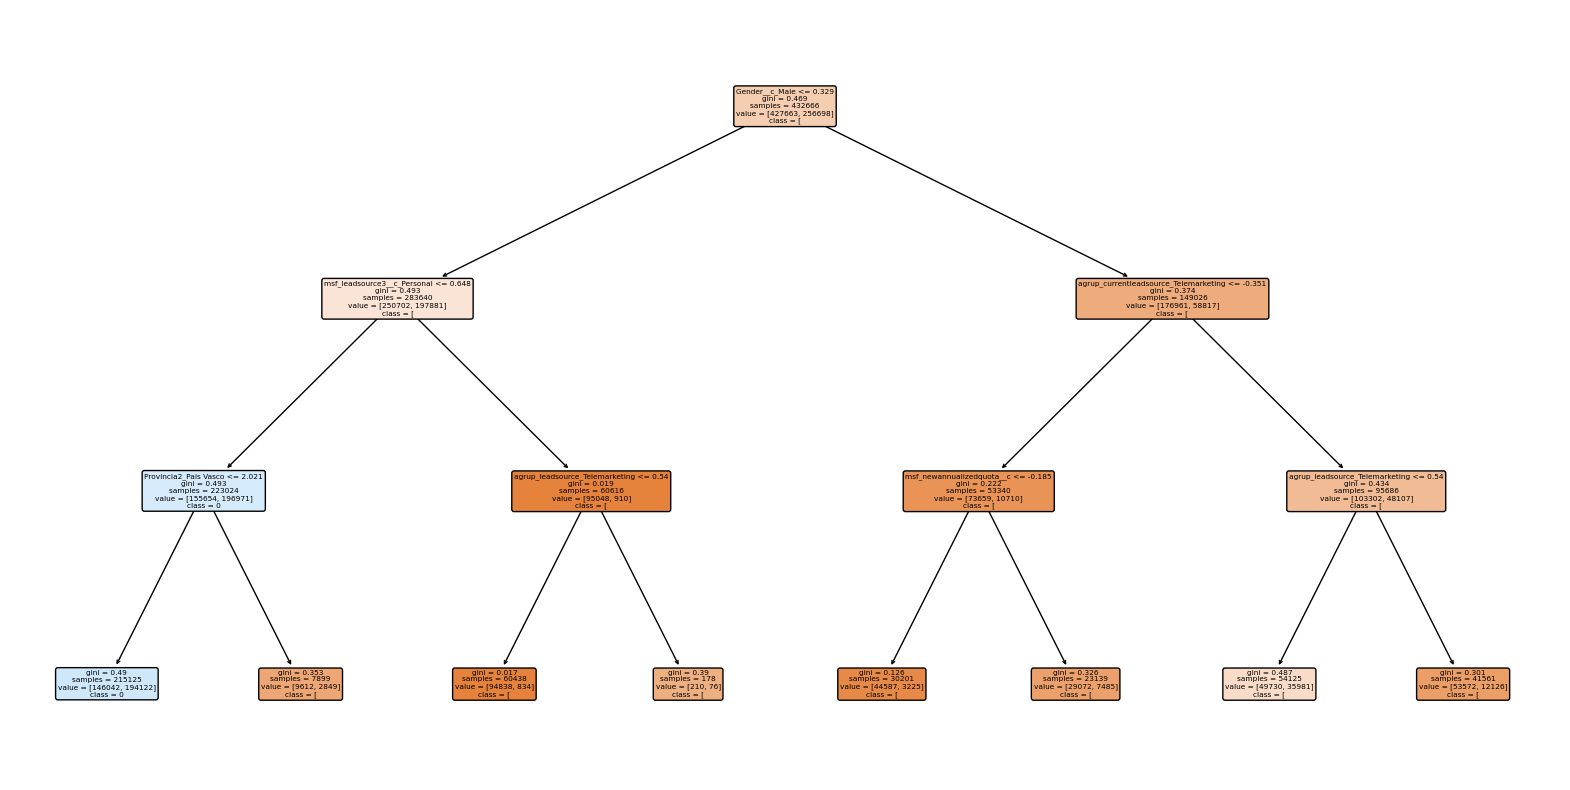

In [208]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
chosen_tree = rf_classifier.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(chosen_tree, filled=True, feature_names=X.columns.tolist(), class_names=str(y.unique()), rounded=True)
plt.show()